In [101]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math



In [103]:
# Load an image
img = mpimg.imread("sphere.jpg")

# Convert to Grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [140]:
def plot_two_images_gray(img_1, img_2, title_1, title_2):

    plt.subplot(1, 2, 1)
    plt.title(title_1)
    plt.imshow(img_1, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title(title_2)
    plt.imshow(img_2, cmap='gray')

def plot_two_images(img_1, img_2, title_1, title_2):

    plt.subplot(1, 2, 1)
    plt.title(title_1)
    plt.imshow(img_1)

    plt.subplot(1, 2, 2)
    plt.title(title_2)
    plt.imshow(img_2)

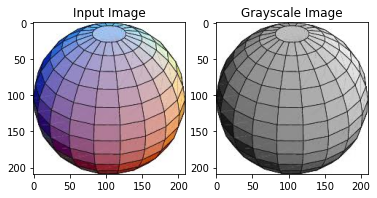

In [104]:
# Plot Input Image and Grayscale
plot_two_images_gray(img, img_gray, "Input Image", "Grayscale Image")

In [105]:
# Gaussian Filter Parameters
window_size = 5
sigma = 5

In [117]:
# Thresholding Values
t_low = 5
t_high = 10

In [107]:
# Gaussian Filter Implememtation

def gauss_filter(window_size, sigma):

    gauss_fil = np.zeros((window_size, window_size))
    for i in range(window_size):
        for j in range(window_size):
            gauss_fil[i, j] = np.exp((-i**2) / (2*(sigma**2))) * np.exp((-j**2) / (2*(sigma**2)))
    
    return gauss_fil


In [108]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

In [109]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size_x = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )

    tgt_size_y = calculate_target_size(
        img_size=img.shape[1],
        kernel_size=kernel.shape[1]
    )
    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size_x, tgt_size_y))
    
    # Iterate over the rows
    for i in range(tgt_size_x):
        # Iterate over the columns
        for j in range(tgt_size_y):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img

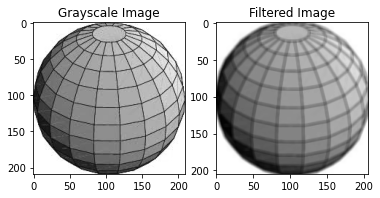

In [116]:
# Convolution of image by Gaussian Filter
img_conv = convolve(img_gray, gauss_filter(window_size, sigma))
plot_two_images_gray(img_gray, img_conv, "Grayscale Image", "Filtered Image")

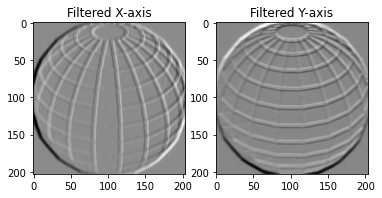

In [111]:
# Filter for horizontal and vertical direction
Gx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])

Gy = np.array([[1, 2, 1],
               [0, 0, 0], 
               [-1, -2, -1]])

#Convolution by image by horizontal and vertical filter

filtered_x = convolve(img_conv, Gx)
filtered_y = convolve(img_conv, Gy)

plot_two_images_gray(filtered_x, filtered_y, "Filtered X-axis", "Filtered Y-axis")

In [144]:
# Calculate directions/orientations
def calc_dir(filtered_x: np.array, filtered_y: np.array) -> np.array:

    height = filtered_x.shape[0]
    width = filtered_x.shape[1]

    theta = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            theta[i,j] = math.atan2(filtered_y[i,j], filtered_x[i,j])
            theta[i,j] = theta[i,j] * 180 / math.pi

    return theta

# Adjustment for negative directions, making all directions positive
def pos_dir(theta: np.array) -> np.array:

    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            if theta[i,j] < 0:
                theta[i,j] = 360 + theta[i,j]
    
    return theta

# Adjusting directions to nearest 0, 45, 90, or 135 degree
def adjust_dir_nearest(theta: np.array) -> np.array:

    theta_adj = np.zeros((theta.shape[0], theta.shape[1]))

    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            if (theta[i,j] >= 0) and (theta[i,j] < 22.5) or (theta[i,j] >= 157.5) and (theta[i,j] < 202.5) or (theta[i,j] >= 337.5) and (theta[i,j] <= 360):
                theta_adj[i,j] = 0
            elif (theta[i,j] >= 22.5) and (theta[i,j] < 67.5) or (theta[i,j] >= 202.5) and (theta[i,j] < 247.5):
                theta_adj[i,j] = 45
            elif (theta[i,j] >= 67.5) and (theta[i,j] < 112.5) or (theta[i,j] >= 247.5) and (theta[i,j] < 292.5):
                theta_adj[i,j] = 90
            elif (theta[i,j] >= 112.5) and (theta[i,j] < 157.5) or (theta[i,j] >= 292.5) and (theta[i,j] < 337.5):
                theta_adj[i,j] = 135

    return theta_adj

In [145]:
theta = calc_dir(filtered_x, filtered_y)

theta = pos_dir(theta)

theta_adjusted = adjust_dir_nearest(theta)

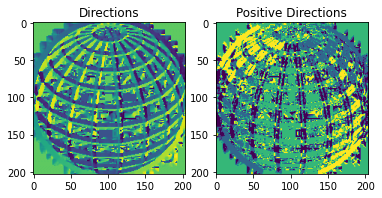

: 

In [146]:
plot_two_images(theta, theta_adjusted, "Directions", "Positive Directions")

In [114]:
# Calculate magnitude of each edge
def calc_mag(filtered_x, filtered_y):

    magnitude = (filtered_x ** 2) + (filtered_y ** 2);
    magnitude_2 = np.sqrt(magnitude);
    
    return magnitude_2

# Non-Maximum Supression
def non_max_supr(magnitude, theta_2):

    BW = np.zeros((magnitude.shape[0], magnitude.shape[1]))

    for i in range(1, magnitude.shape[0]-1):
        for j in range(1, magnitude.shape[1]-1):
                if theta_2[i,j] == 0:
                    BW[i,j] = magnitude[i,j] == max([magnitude[i,j], magnitude[i,j+1], magnitude[i,j-1]])
                elif theta_2[i,j] == 45:
                    BW[i,j] = magnitude[i,j] == max([magnitude[i,j], magnitude[i+1,j+1], magnitude[i-1,j-1]])
                elif theta_2[i,j] == 90:
                    BW[i,j] = magnitude[i,j] == max([magnitude[i,j], magnitude[i+1,j], magnitude[i-1,j]])
                elif theta_2[i,j] == 135:
                    BW[i,j] = magnitude[i,j] == max([magnitude[i,j], magnitude[i+1,j-1], magnitude[i-1,j+1]])

    return BW


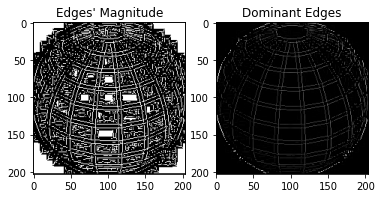

In [115]:
magn = calc_mag(filtered_x, filtered_y)

BW = non_max_supr(magn, theta_adjusted)

# Keeping only the most Dominant Edges in a Neighborhood
dom_BW = np.multiply(magn, BW)


plot_two_images_gray(BW, dom_BW, "Edges\' Magnitude", "Dominant Edges")

In [129]:
# Hysteresis Thresholding

def hysterisis_thresh(BW: np.array, t_low: int, t_high: int) -> np.array:

    t_low = (t_low/255) * np.max(BW)
    t_high = (t_high/255) * np.max(BW)

    height, width = BW.shape[0], BW.shape[1]

    t_res = np.zeros((height, width))

    for i in range(height-1):
        for j in range(width-1):
           t_res[i,j] = 1 if ((BW[i+1,j]   > t_high or BW[i-1,j]    > t_high or 
                              BW[i,j+1]    > t_high or BW[i,j-1]    > t_high or 
                              BW[i-1, j-1] > t_high or BW[i-1, j+1] > t_high or
                              BW[i+1,j+1]  > t_high or BW[i+1,j-1]  > t_high) or BW[i,j] > t_high) else 0

    return t_res

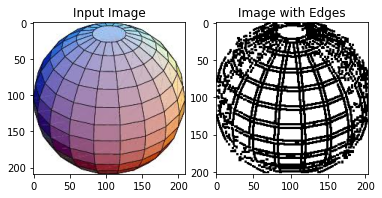

In [139]:
img_edges = 255 - (hysterisis_thresh(dom_BW, t_low, t_high) *  255)

plot_two_images_gray(img, img_edges, "Input Image", "Image with Edges")